In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from timm import create_model
from colorama import Fore, Style, init
import shutil
import random
from pathlib import Path

In [7]:
# ==============================
# 1 Augmentation
# ==============================

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(260), #If u want to use weaker, or stronger model, u need to change the size of the pics.: #b0 224  #b3 300 
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), 
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(288), #256 b0, b3 320
        transforms.CenterCrop(260), #b0 224, b3 300
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),}

In [9]:
from pathlib import Path

data_dir = "Fish"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)


['Common_roach', 'Grass_carp', 'Ruffe']


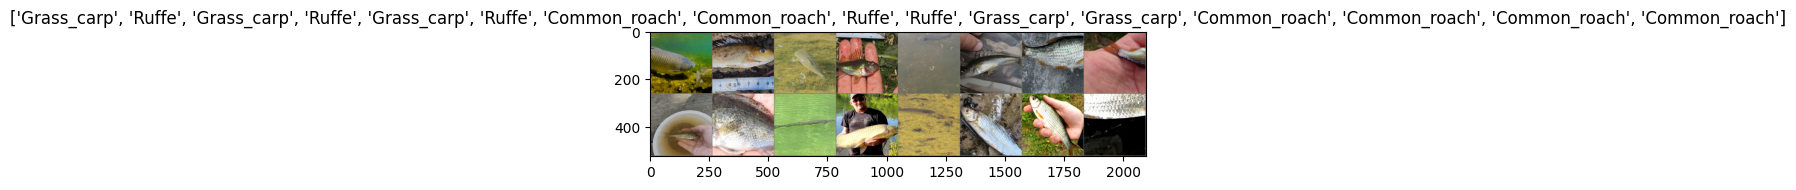

In [10]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=12):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
#Load a pretrained model and reset final fully connected layer.
model = models.efficientnet_b2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=0.00005) #Change the learning rate, if u want.

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=10)  #Probably 10 epochs is good

Epoch 0/9
----------
train Loss: 0.7656 Acc: 0.7113
val Loss: 0.3268 Acc: 0.9238

Epoch 1/9
----------
train Loss: 0.3777 Acc: 0.8681
val Loss: 0.1376 Acc: 0.9595

Epoch 2/9
----------
train Loss: 0.2515 Acc: 0.9094
val Loss: 0.1125 Acc: 0.9667

Epoch 3/9
----------
train Loss: 0.2099 Acc: 0.9236
val Loss: 0.0929 Acc: 0.9714

Epoch 4/9
----------
train Loss: 0.1805 Acc: 0.9364
val Loss: 0.0870 Acc: 0.9762

Epoch 5/9
----------
train Loss: 0.1661 Acc: 0.9333
val Loss: 0.0809 Acc: 0.9714

Epoch 6/9
----------
train Loss: 0.1462 Acc: 0.9476
val Loss: 0.0685 Acc: 0.9833

Epoch 7/9
----------
train Loss: 0.1247 Acc: 0.9603
val Loss: 0.0656 Acc: 0.9833

Epoch 8/9
----------
train Loss: 0.1336 Acc: 0.9486
val Loss: 0.0607 Acc: 0.9810

Epoch 9/9
----------
train Loss: 0.1281 Acc: 0.9552
val Loss: 0.0567 Acc: 0.9833

Training complete in 15m 36s
Best val Acc: 0.983333


In [ ]:
# 1. Freeze all block
#for param in model.parameters():
    #param.requires_grad = False

# features modul, conventional block unfreeze 
#for param in model.features[-3:].parameters():  #last 3 block
    #param.requires_grad = True

#Unfreeze the classifier layer
#for param in model.classifier.parameters():
    #param.requires_grad = True

#criterion = nn.CrossEntropyLoss()

#optimizer = torch.optim.Adam([
    #{'params': model.features[-3:].parameters(), 'lr': 1e-5},
    #{'params': model.classifier.parameters(), 'lr': 1e-4}])

#Lr decreasing
#scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

#check
#trainable = sum(p.requires_grad for p in model.parameters())
#total = sum(1 for _ in model.parameters())
#print(f"Tanítható rétegek: {trainable}/{total}")

#training 
#model = train_model(model, criterion, optimizer, scheduler, num_epochs=6)

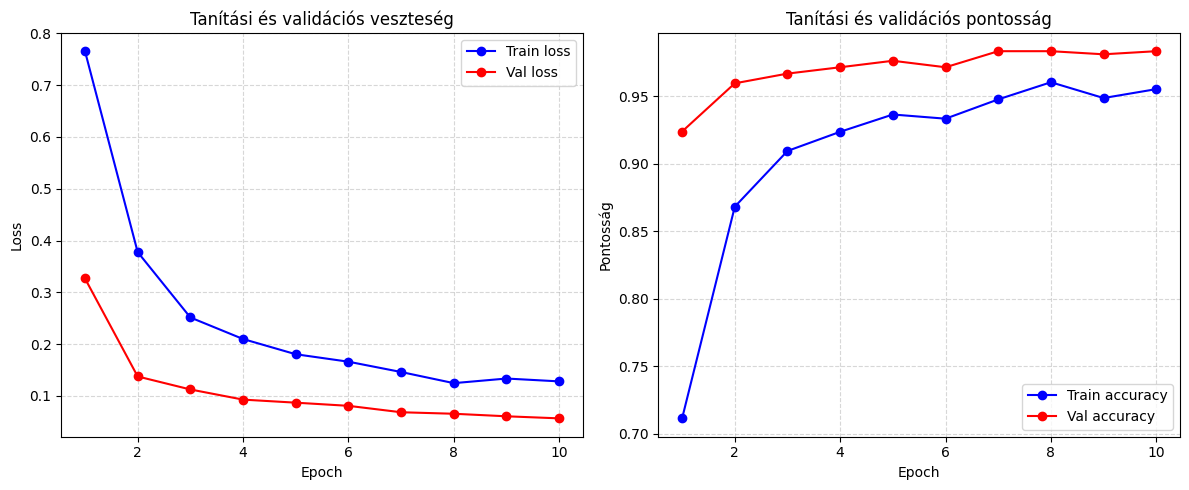

In [15]:
train_losses = [0.7656, 0.3777, 0.2515, 0.2099, 0.1805, 0.1661, 0.1462, 0.1247, 0.1336, 0.1281]
val_losses   = [0.3268, 0.1376, 0.1125, 0.0929, 0.0870, 0.0809, 0.0685, 0.0656, 0.0607, 0.0567]
train_accs  = [0.7113, 0.8681, 0.9094, 0.9236, 0.9364, 0.9333, 0.9476, 0.9603, 0.9486, 0.9552]
val_accs    = [0.9238, 0.9595, 0.9667, 0.9714, 0.9762, 0.9714, 0.9833, 0.9833, 0.9810, 0.9833]

epochs = range(1, len(train_losses) + 1)


plt.figure(figsize=(12,5))

# --- Loss plot ---
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, 'bo-', label='Train loss')
plt.plot(epochs, val_losses, 'ro-', label='Val loss')
plt.title('Tanítási és validációs veszteség')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# --- Accuracy plot ---
plt.subplot(1,2,2)
plt.plot(epochs, train_accs, 'bo-', label='Train accuracy')
plt.plot(epochs, val_accs, 'ro-', label='Val accuracy')
plt.title('Tanítási és validációs pontosság')
plt.xlabel('Epoch')
plt.ylabel('Pontosság')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


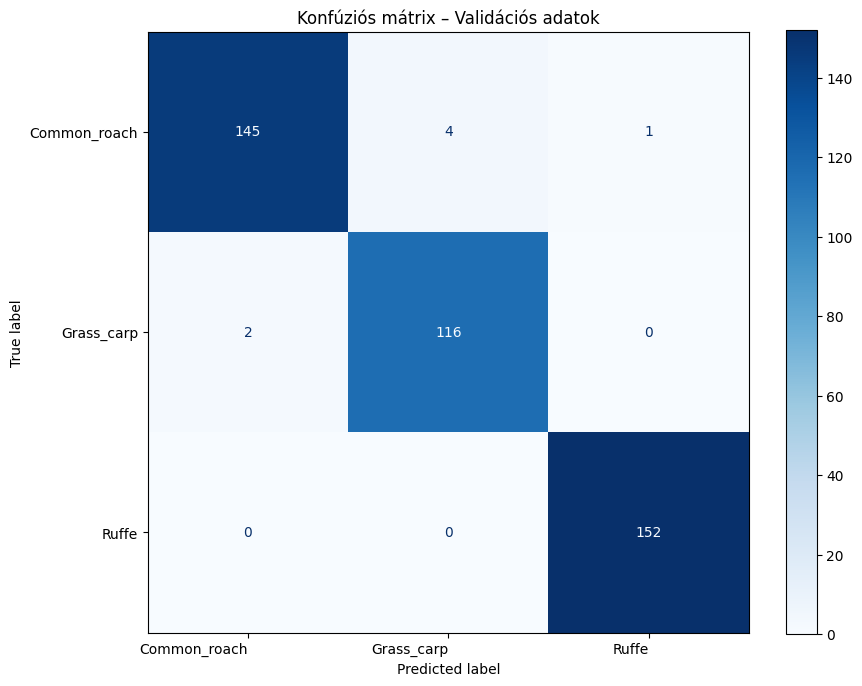

In [16]:
#Model evaluation mode
model.eval()

all_preds = []
all_labels = []

#Forward pass in the validition data
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(9, 7))
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")

plt.title('Konfúziós mátrix – Validációs adatok')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()


In [17]:
print("Metrics in clasess \n")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=3))

overall_acc = accuracy_score(all_labels, all_preds)
print(f"Average accuracy: {overall_acc:.3f}")

Metrics in clasess 

              precision    recall  f1-score   support

Common_roach      0.986     0.967     0.976       150
  Grass_carp      0.967     0.983     0.975       118
       Ruffe      0.993     1.000     0.997       152

    accuracy                          0.983       420
   macro avg      0.982     0.983     0.983       420
weighted avg      0.983     0.983     0.983       420

Average accuracy: 0.983


In [18]:
torch.save(model, 'Effb2_model.pth')